In [1]:
# MNISTのVAEによる予測
# 参考元 → "https://academ-aid.com/ml/vae#index_id1"

In [2]:
%%HTML
<style>
    div#notebook-container    { width: 65%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [3]:
# ライブラリ

import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.datasets import mnist

import random
from tqdm.notebook import tqdm

2023-08-09 07:58:55.730648: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def plot_MNIST(X_data, y_data):
    """

    MNISTのデータを正解ラベルとともにプロットする

    Parameters
    ----------
    X_data : numpy.ndarray
        数字のモノクロデータ。2次元配列。
        
    y_data : numpy.ndarray
        数字の正解ラベル。1次元配列。

    Returns
    ----------
    None
    """
    
    fig = plt.figure(figsize=(10, 6), tight_layout=True)
    
    for i in range(10):
        target = X_data[y_data==i]
            
        ax = fig.add_subplot(2, 5, i+1)
        ax.axis("off")
    
        ax.set_title("label:{}, data:{}".format(i,len(target)), y=-0.15)
        ax.imshow(target[0], cmap='gray')
        
    return

In [5]:
# データのロード

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [7]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [8]:
X_test

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [9]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [10]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [11]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [12]:
X_train.max(), X_train.min()

(255, 0)

In [13]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

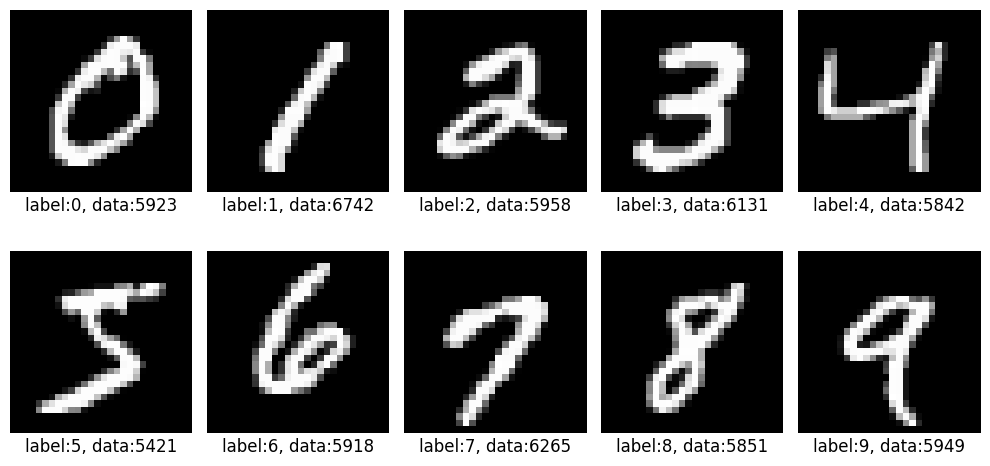

In [14]:
plot_MNIST(X_train, y_train)

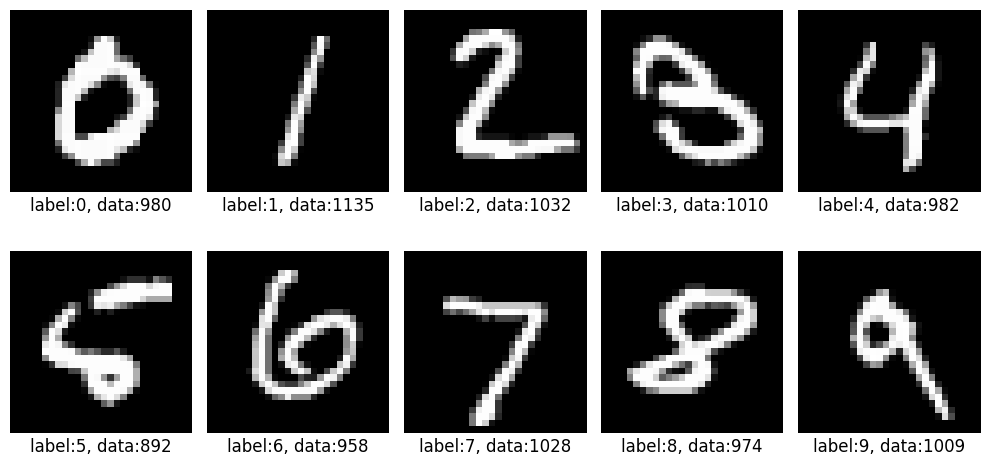

In [15]:
plot_MNIST(X_test, y_test)

In [16]:
# 1次元に変形して正規化

X_train_convert = np.reshape(X_train, [-1, 784])/255
X_test_convert = np.reshape(X_test, [-1, 784])/255

In [17]:
X_train_convert

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
X_test_convert

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
X_train_convert.max(), X_test_convert.max()

(1.0, 1.0)

In [20]:
X_train_convert.shape, X_test_convert.shape

((60000, 784), (10000, 784))

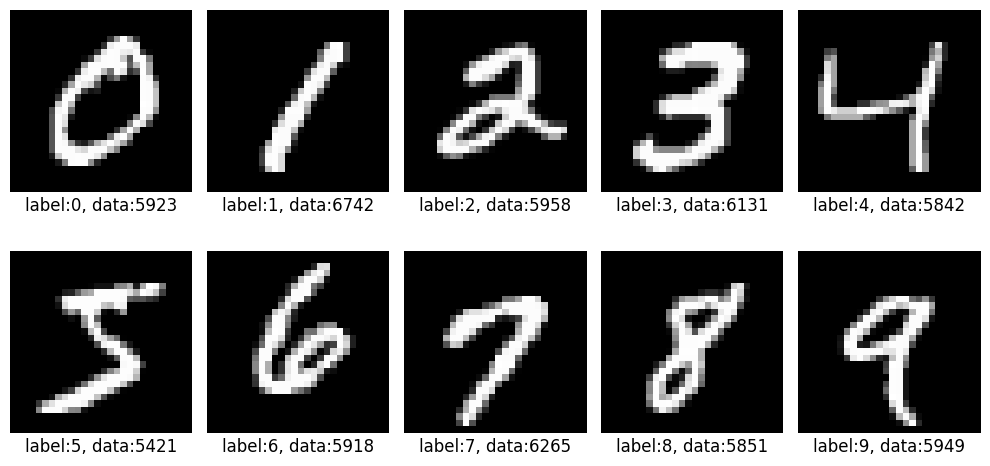

In [21]:
# 情報が失われていないことを確認

plot_MNIST(np.reshape(X_train_convert, [-1,28,28]), y_train)

In [22]:
class Sampling(keras.layers.Layer):
    """
    VAEにおけるサンプリングレイヤー。
    tensorflow.kerasのlayers.Layerクラスを継承。
    
    Attributes
    ----------
    None
    """    
    
    def call(self, inputs):
        """
        Parameters
        ----------
        inputs : list
            サンプリングに用いる統計量の含まれたリスト。
            inputs[0]は潜在空間の平均，inputs[1]は潜在空間の分散の自然対数。
            
        Returns
        ----------
        z_sampled : numpy.ndarray
            サンプリングした潜在変数。
        """
        
        z_mean, z_log_var = inputs
        
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z_sampled = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        return z_sampled

In [23]:
# とりあえずパラメータ固定のモデルを作ってみる

z_dim = 2

In [24]:
# エンコーダ

encoder_inputs = Input(shape=(784, ))

x = Dense(400, activation="relu", kernel_initializer="he_normal")(encoder_inputs)
x = Dense(200, activation="relu", kernel_initializer="he_normal")(x)

z_mean = Dense(z_dim, name="z_mean")(x)
z_log_var = Dense(z_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

2023-08-09 07:58:59.282488: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 07:58:59.371181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9195 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6


In [25]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 400)          314000      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 200)          80200       ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 2)            402         ['dense_1[0][0]']                
                                                                                            

In [26]:
# デコーダ

decoder_inputs = keras.Input(shape=(z_dim,))
x = Dense(200, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x = Dense(400, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(rate=0.2)(x)
decoder_outputs = Dense(784, activation="sigmoid", kernel_initializer="glorot_normal")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

In [27]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 200)               600       
                                                                 
 dense_3 (Dense)             (None, 400)               80400     
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 784)               314384    
                                                                 
Total params: 395,384
Trainable params: 395,384
Non-trainable params: 0
_________________________________________________________________


In [28]:
class VAE(keras.Model):
    """
    keras.Modelクラスを継承したサブクラス。
    VAEの特殊な損失関数による学習をサポートする。
    
    Attributes
    ----------
    encoder : keras.engine.functional.Functional
        構築したencoderモデル。
        
    decoder : keras.engine.functional.Functional
        構築したdecoderモデル。
        
    total_loss_tracker : keras.metrics.base_metric.Mean
        total_loss_tracker（誤差の総和）を計算するためのインスタンス。

    reconstruction_loss_tracker : keras.metrics.base_metric.Mean
        reconstruction_loss_tracker（再構成誤差）を計算するためのインスタンス。

    kl_loss_tracker : keras.metrics.base_metric.Mean
        kl_loss_tracker（KLダイバージェンス）を計算するためのインスタンス。
    """    
    
    def __init__(self, encoder, decoder, **kwargs):
        """
        インスタンス化の際に呼ばれる初期化関数。
        
        Parameters
        ----------
        encoder : keras.engine.functional.Functional
            構築したencoderモデル。
        
        decoder : keras.engine.functional.Functional
            構築したdecoderモデル。
            
        Returns
        ----------
        None
        """
        
        # 親クラスのメソッドによる初期化
        super().__init__(**kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        metricsのオーバーライドメソッド。
        正直良くわかっていないが、Keraにおいて内部的に呼ばれるだけの関数なので余り気にしない。
        
        Parameters
        ----------
        None
            
        Returns
        ----------
        metrics_list : list
            インスタンスに属している誤差関数のリスト。総和誤差、再構成誤差、KLダイバージェンスの順に格納されている。
        """
        
        metrics_list = [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
        
        return metrics_list

    def train_step(self, data):
        """
        train_stepのオーバーライドメソッド。
        損失関数・勾配の計算，重みの更新を行うメソッド。
        名前や中身的にエポック毎やバッチ毎に呼び出されるのかと思いきやそうではない。
        
        Parameters
        ----------
        data : tensorflow.python.framework.ops.Tensor
            学習に用いるデータ（多分）。
            
        Returns
        ----------
        loss_map : dict
            損失関数の辞書
            
        """
        
        # loss
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)

            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        # gradient
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        loss_map = {
                    "loss": self.total_loss_tracker.result(),
                    "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                    "kl_loss": self.kl_loss_tracker.result(),
                   }

        return loss_map

In [29]:
vae_dim2 = VAE(encoder, decoder)
vae_dim2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [30]:
early_stopping = EarlyStopping(monitor="loss", min_delta=0, patience=10, verbose=0, mode="min")

In [31]:
history_dim2 = vae_dim2.fit(X_train_convert, epochs=1000, batch_size=1000, verbose=1, callbacks=[early_stopping])

Epoch 1/1000


2023-08-09 07:59:01.300584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-09 07:59:01.335934: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4b559bc7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-09 07:59:01.335966: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-08-09 07:59:01.341938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-09 07:59:01.470111: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 [==============================] - 3s 5ms/step - loss: 401.5634 - reconstruction_loss: 296.2340 - kl_loss: 5.0318
Epoch 2/1000
60/60 [==============================] - 0s 5ms/step - loss: 237.9759 - reconstruction_loss: 229.0696 - kl_loss: 5.6719
Epoch 3/1000
60/60 [==============================] - 0s 5ms/step - loss: 229.2508 - reconstruction_loss: 222.1619 - kl_loss: 5.7487
Epoch 4/1000
60/60 [==============================] - 0s 5ms/step - loss: 224.4279 - reconstruction_loss: 216.9791 - kl_loss: 5.8092
Epoch 5/1000
60/60 [==============================] - 0s 5ms/step - loss: 217.9340 - reconstruction_loss: 210.9842 - kl_loss: 5.8615
Epoch 6/1000
60/60 [==============================] - 0s 5ms/step - loss: 213.0176 - reconstruction_loss: 204.9818 - kl_loss: 5.9128
Epoch 7/1000
60/60 [==============================] - 0s 4ms/step - loss: 206.3412 - reconstruction_loss: 199.6914 - kl_loss: 6.0117
Epoch 8/1000
60/60 [==============================] - 0s 5ms/step - loss: 202.2081

60/60 [==============================] - 0s 4ms/step - loss: 170.0583 - reconstruction_loss: 162.4525 - kl_loss: 7.3970
Epoch 124/1000
60/60 [==============================] - 0s 5ms/step - loss: 169.8725 - reconstruction_loss: 162.4047 - kl_loss: 7.4074
Epoch 125/1000
60/60 [==============================] - 0s 4ms/step - loss: 169.5638 - reconstruction_loss: 162.3611 - kl_loss: 7.3760
Epoch 126/1000
60/60 [==============================] - 0s 5ms/step - loss: 169.6038 - reconstruction_loss: 162.2156 - kl_loss: 7.3925
Epoch 127/1000
60/60 [==============================] - 0s 5ms/step - loss: 169.7388 - reconstruction_loss: 162.3330 - kl_loss: 7.4050
Epoch 128/1000
60/60 [==============================] - 0s 4ms/step - loss: 169.7004 - reconstruction_loss: 162.4202 - kl_loss: 7.3951
Epoch 129/1000
60/60 [==============================] - 0s 4ms/step - loss: 169.2666 - reconstruction_loss: 162.1654 - kl_loss: 7.4124
Epoch 130/1000
60/60 [==============================] - 0s 5ms/step - 

60/60 [==============================] - 0s 5ms/step - loss: 166.0428 - reconstruction_loss: 158.2496 - kl_loss: 7.6759
Epoch 244/1000
60/60 [==============================] - 0s 4ms/step - loss: 166.1573 - reconstruction_loss: 158.3660 - kl_loss: 7.6651
Epoch 245/1000
60/60 [==============================] - 0s 5ms/step - loss: 166.1871 - reconstruction_loss: 158.2353 - kl_loss: 7.6725
Epoch 246/1000
60/60 [==============================] - 0s 4ms/step - loss: 165.9390 - reconstruction_loss: 158.2354 - kl_loss: 7.6740
Epoch 247/1000
60/60 [==============================] - 0s 5ms/step - loss: 165.7179 - reconstruction_loss: 158.1620 - kl_loss: 7.6771
Epoch 248/1000
60/60 [==============================] - 0s 4ms/step - loss: 165.9378 - reconstruction_loss: 158.2022 - kl_loss: 7.6768
Epoch 249/1000
60/60 [==============================] - 0s 5ms/step - loss: 165.6337 - reconstruction_loss: 158.1510 - kl_loss: 7.6799
Epoch 250/1000
60/60 [==============================] - 0s 5ms/step - 

60/60 [==============================] - 0s 5ms/step - loss: 163.1891 - reconstruction_loss: 155.5454 - kl_loss: 7.9008
Epoch 364/1000
60/60 [==============================] - 0s 5ms/step - loss: 163.2527 - reconstruction_loss: 155.6055 - kl_loss: 7.8789
Epoch 365/1000
60/60 [==============================] - 0s 4ms/step - loss: 163.5105 - reconstruction_loss: 155.5510 - kl_loss: 7.9061
Epoch 366/1000
60/60 [==============================] - 0s 5ms/step - loss: 163.5812 - reconstruction_loss: 155.7207 - kl_loss: 7.8926
Epoch 367/1000
60/60 [==============================] - 0s 5ms/step - loss: 163.2675 - reconstruction_loss: 155.5700 - kl_loss: 7.8843
Epoch 368/1000
60/60 [==============================] - 0s 5ms/step - loss: 163.1186 - reconstruction_loss: 155.5476 - kl_loss: 7.8965
Epoch 369/1000
60/60 [==============================] - 0s 5ms/step - loss: 163.5815 - reconstruction_loss: 155.5776 - kl_loss: 7.8970
Epoch 370/1000
60/60 [==============================] - 0s 5ms/step - 

60/60 [==============================] - 0s 5ms/step - loss: 161.6322 - reconstruction_loss: 153.6497 - kl_loss: 8.0694
Epoch 484/1000
60/60 [==============================] - 0s 5ms/step - loss: 161.9106 - reconstruction_loss: 153.8038 - kl_loss: 8.0642
Epoch 485/1000
60/60 [==============================] - 0s 4ms/step - loss: 162.1326 - reconstruction_loss: 153.7892 - kl_loss: 8.0614
Epoch 486/1000
60/60 [==============================] - 0s 5ms/step - loss: 162.0126 - reconstruction_loss: 153.8056 - kl_loss: 8.0583
Epoch 487/1000
60/60 [==============================] - 0s 5ms/step - loss: 161.7932 - reconstruction_loss: 153.7159 - kl_loss: 8.0508
Epoch 488/1000
60/60 [==============================] - 0s 5ms/step - loss: 161.6556 - reconstruction_loss: 153.7670 - kl_loss: 8.0627
Epoch 489/1000
60/60 [==============================] - 0s 4ms/step - loss: 161.6234 - reconstruction_loss: 153.6033 - kl_loss: 8.0518
Epoch 490/1000
60/60 [==============================] - 0s 5ms/step - 

60/60 [==============================] - 0s 4ms/step - loss: 160.2301 - reconstruction_loss: 152.4707 - kl_loss: 8.1830
Epoch 604/1000
60/60 [==============================] - 0s 5ms/step - loss: 160.3446 - reconstruction_loss: 152.3914 - kl_loss: 8.1692
Epoch 605/1000
60/60 [==============================] - 0s 5ms/step - loss: 160.3057 - reconstruction_loss: 152.2614 - kl_loss: 8.1945
Epoch 606/1000
60/60 [==============================] - 0s 5ms/step - loss: 160.1707 - reconstruction_loss: 152.3710 - kl_loss: 8.1928
Epoch 607/1000
60/60 [==============================] - 0s 5ms/step - loss: 160.4317 - reconstruction_loss: 152.2634 - kl_loss: 8.2013
Epoch 608/1000
60/60 [==============================] - 0s 5ms/step - loss: 160.1072 - reconstruction_loss: 152.2318 - kl_loss: 8.1883
Epoch 609/1000
60/60 [==============================] - 0s 5ms/step - loss: 160.4525 - reconstruction_loss: 152.2032 - kl_loss: 8.1995
Epoch 610/1000
60/60 [==============================] - 0s 5ms/step - 

In [32]:
pd.DataFrame(history_dim2.history)

loss  reconstruction_loss   kl_loss
0    301.265778           296.234009  5.031828
1    234.741486           229.069565  5.671859
2    227.910614           222.161880  5.748739
3    222.788162           216.979080  5.809153
4    216.845718           210.984207  5.861476
..          ...                  ...       ...
680  159.865295           151.596603  8.268741
681  159.886581           151.632080  8.254503
682  159.849167           151.604156  8.245040
683  159.970230           151.714279  8.255943
684  159.889633           151.638733  8.250870

[685 rows x 3 columns]

<AxesSubplot: >

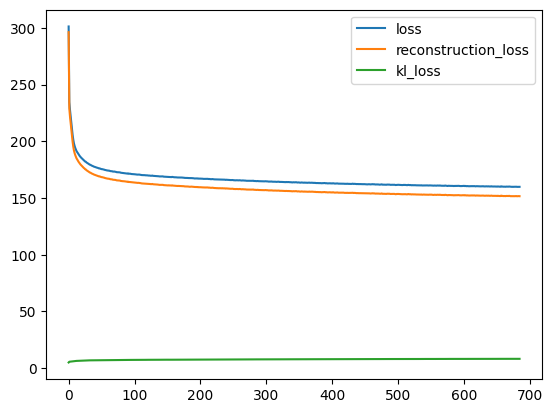

In [33]:
pd.DataFrame(history_dim2.history)[["loss", "reconstruction_loss", "kl_loss"]].plot()

In [34]:
# 潜在変数の次元数を変化させてみる

z_dim = 10

encoder_inputs = Input(shape=(784, ))

x = Dense(400, activation="relu", kernel_initializer="he_normal")(encoder_inputs)
x = Dense(200, activation="relu", kernel_initializer="he_normal")(x)

z_mean = Dense(z_dim, name="z_mean")(x)
z_log_var = Dense(z_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

decoder_inputs = keras.Input(shape=(z_dim,))
x = Dense(200, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x = Dense(400, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(rate=0.2)(x)
decoder_outputs = Dense(784, activation="sigmoid", kernel_initializer="glorot_normal")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

vae_dim10 = VAE(encoder, decoder)
vae_dim10.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

history_dim10 = vae_dim10.fit(X_train_convert, epochs=1000, batch_size=1000, verbose=1, callbacks=[early_stopping])

Epoch 1/1000
60/60 [==============================] - 2s 4ms/step - loss: 399.8916 - reconstruction_loss: 288.5768 - kl_loss: 8.2073
Epoch 2/1000
60/60 [==============================] - 0s 4ms/step - loss: 201.5553 - reconstruction_loss: 175.4234 - kl_loss: 15.2639
Epoch 3/1000
60/60 [==============================] - 0s 5ms/step - loss: 170.5301 - reconstruction_loss: 149.8377 - kl_loss: 17.1841
Epoch 4/1000
60/60 [==============================] - 0s 5ms/step - loss: 158.5418 - reconstruction_loss: 138.9986 - kl_loss: 17.9443
Epoch 5/1000
60/60 [==============================] - 0s 5ms/step - loss: 152.7069 - reconstruction_loss: 133.3678 - kl_loss: 18.2817
Epoch 6/1000
60/60 [==============================] - 0s 4ms/step - loss: 148.7437 - reconstruction_loss: 129.5070 - kl_loss: 18.5535
Epoch 7/1000
60/60 [==============================] - 0s 5ms/step - loss: 145.9544 - reconstruction_loss: 126.6645 - kl_loss: 18.7027
Epoch 8/1000
60/60 [==============================] - 0s 5ms/st

60/60 [==============================] - 0s 5ms/step - loss: 121.0359 - reconstruction_loss: 100.2461 - kl_loss: 20.9411
Epoch 122/1000
60/60 [==============================] - 0s 4ms/step - loss: 120.9509 - reconstruction_loss: 100.2109 - kl_loss: 20.9452
Epoch 123/1000
60/60 [==============================] - 0s 5ms/step - loss: 121.1386 - reconstruction_loss: 100.1291 - kl_loss: 20.9604
Epoch 124/1000
60/60 [==============================] - 0s 5ms/step - loss: 120.9049 - reconstruction_loss: 100.1362 - kl_loss: 20.9408
Epoch 125/1000
60/60 [==============================] - 0s 5ms/step - loss: 121.0472 - reconstruction_loss: 100.0727 - kl_loss: 20.9462
Epoch 126/1000
60/60 [==============================] - 0s 5ms/step - loss: 120.8569 - reconstruction_loss: 99.9911 - kl_loss: 20.9482
Epoch 127/1000
60/60 [==============================] - 0s 5ms/step - loss: 120.6146 - reconstruction_loss: 99.9260 - kl_loss: 20.9664
Epoch 128/1000
60/60 [==============================] - 0s 5ms/st

60/60 [==============================] - 0s 5ms/step - loss: 117.9965 - reconstruction_loss: 96.9880 - kl_loss: 21.2563
Epoch 242/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.0289 - reconstruction_loss: 96.9773 - kl_loss: 21.2502
Epoch 243/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.2190 - reconstruction_loss: 96.9995 - kl_loss: 21.2831
Epoch 244/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.1323 - reconstruction_loss: 96.9452 - kl_loss: 21.2820
Epoch 245/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.1191 - reconstruction_loss: 96.9004 - kl_loss: 21.2934
Epoch 246/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.3388 - reconstruction_loss: 96.9251 - kl_loss: 21.2942
Epoch 247/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.2114 - reconstruction_loss: 96.9184 - kl_loss: 21.2872
Epoch 248/1000
60/60 [==============================] - 0s 4ms/step - 

60/60 [==============================] - 0s 4ms/step - loss: 116.9182 - reconstruction_loss: 95.5230 - kl_loss: 21.4083
Epoch 362/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.8583 - reconstruction_loss: 95.5149 - kl_loss: 21.4199
Epoch 363/1000
60/60 [==============================] - 0s 5ms/step - loss: 117.0949 - reconstruction_loss: 95.5578 - kl_loss: 21.4214
Epoch 364/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.6843 - reconstruction_loss: 95.4669 - kl_loss: 21.4325
Epoch 365/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.7591 - reconstruction_loss: 95.4790 - kl_loss: 21.4109
Epoch 366/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.9024 - reconstruction_loss: 95.4883 - kl_loss: 21.4156
Epoch 367/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.9269 - reconstruction_loss: 95.4303 - kl_loss: 21.4179
Epoch 368/1000
60/60 [==============================] - 0s 5ms/step - 

60/60 [==============================] - 0s 4ms/step - loss: 115.8667 - reconstruction_loss: 94.5758 - kl_loss: 21.5056
Epoch 482/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.1571 - reconstruction_loss: 94.5811 - kl_loss: 21.5058
Epoch 483/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.0488 - reconstruction_loss: 94.6070 - kl_loss: 21.5031
Epoch 484/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.1408 - reconstruction_loss: 94.5420 - kl_loss: 21.5122
Epoch 485/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.1878 - reconstruction_loss: 94.5925 - kl_loss: 21.5035
Epoch 486/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.0054 - reconstruction_loss: 94.5335 - kl_loss: 21.4966
Epoch 487/1000
60/60 [==============================] - 0s 5ms/step - loss: 115.8733 - reconstruction_loss: 94.5703 - kl_loss: 21.5092
Epoch 488/1000
60/60 [==============================] - 0s 5ms/step - 

<AxesSubplot: >

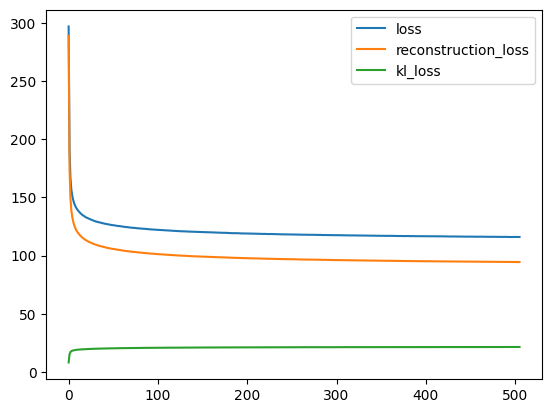

In [35]:
pd.DataFrame(history_dim10.history)[["loss", "reconstruction_loss", "kl_loss"]].plot()

In [36]:
z_dim = 20

encoder_inputs = Input(shape=(784, ))

x = Dense(400, activation="relu", kernel_initializer="he_normal")(encoder_inputs)
x = Dense(200, activation="relu", kernel_initializer="he_normal")(x)

z_mean = Dense(z_dim, name="z_mean")(x)
z_log_var = Dense(z_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

decoder_inputs = keras.Input(shape=(z_dim,))
x = Dense(200, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x = Dense(400, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(rate=0.2)(x)
decoder_outputs = Dense(784, activation="sigmoid", kernel_initializer="glorot_normal")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

vae_dim20 = VAE(encoder, decoder)
vae_dim20.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

history_dim20 = vae_dim20.fit(X_train_convert, epochs=1000, batch_size=1000, verbose=1, callbacks=[early_stopping])

Epoch 1/1000
60/60 [==============================] - 2s 4ms/step - loss: 399.1930 - reconstruction_loss: 292.1087 - kl_loss: 7.5742
Epoch 2/1000
60/60 [==============================] - 0s 5ms/step - loss: 206.1162 - reconstruction_loss: 177.9641 - kl_loss: 17.3450
Epoch 3/1000
60/60 [==============================] - 0s 4ms/step - loss: 172.6979 - reconstruction_loss: 146.5182 - kl_loss: 22.2032
Epoch 4/1000
60/60 [==============================] - 0s 5ms/step - loss: 158.4991 - reconstruction_loss: 131.9813 - kl_loss: 24.4152
Epoch 5/1000
60/60 [==============================] - 0s 5ms/step - loss: 150.7578 - reconstruction_loss: 123.8370 - kl_loss: 25.5400
Epoch 6/1000
60/60 [==============================] - 0s 4ms/step - loss: 145.8553 - reconstruction_loss: 118.7871 - kl_loss: 26.2772
Epoch 7/1000
60/60 [==============================] - 0s 5ms/step - loss: 142.6693 - reconstruction_loss: 115.4225 - kl_loss: 26.7391
Epoch 8/1000
60/60 [==============================] - 0s 5ms/st

60/60 [==============================] - 0s 5ms/step - loss: 122.3739 - reconstruction_loss: 94.1176 - kl_loss: 28.2003
Epoch 63/1000
60/60 [==============================] - 0s 5ms/step - loss: 122.2247 - reconstruction_loss: 94.0197 - kl_loss: 28.1602
Epoch 64/1000
60/60 [==============================] - 0s 5ms/step - loss: 121.9659 - reconstruction_loss: 93.8743 - kl_loss: 28.1462
Epoch 65/1000
60/60 [==============================] - 0s 5ms/step - loss: 122.0714 - reconstruction_loss: 93.9545 - kl_loss: 28.1478
Epoch 66/1000
60/60 [==============================] - 0s 5ms/step - loss: 121.8417 - reconstruction_loss: 93.7637 - kl_loss: 28.1476
Epoch 67/1000
60/60 [==============================] - 0s 5ms/step - loss: 121.8793 - reconstruction_loss: 93.6721 - kl_loss: 28.1563
Epoch 68/1000
60/60 [==============================] - 0s 5ms/step - loss: 121.8052 - reconstruction_loss: 93.6536 - kl_loss: 28.1520
Epoch 69/1000
60/60 [==============================] - 0s 5ms/step - loss: 1

60/60 [==============================] - 0s 5ms/step - loss: 119.1809 - reconstruction_loss: 91.2260 - kl_loss: 27.9492
Epoch 124/1000
60/60 [==============================] - 0s 5ms/step - loss: 119.2415 - reconstruction_loss: 91.2378 - kl_loss: 27.9171
Epoch 125/1000
60/60 [==============================] - 0s 5ms/step - loss: 119.1985 - reconstruction_loss: 91.1253 - kl_loss: 27.9240
Epoch 126/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.9310 - reconstruction_loss: 91.0954 - kl_loss: 27.8995
Epoch 127/1000
60/60 [==============================] - 0s 5ms/step - loss: 119.1771 - reconstruction_loss: 91.1075 - kl_loss: 27.8848
Epoch 128/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.8087 - reconstruction_loss: 91.0547 - kl_loss: 27.9080
Epoch 129/1000
60/60 [==============================] - 0s 5ms/step - loss: 118.7779 - reconstruction_loss: 91.0925 - kl_loss: 27.8877
Epoch 130/1000
60/60 [==============================] - 0s 5ms/step - 

60/60 [==============================] - 0s 5ms/step - loss: 116.7988 - reconstruction_loss: 89.1646 - kl_loss: 27.5405
Epoch 244/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.6222 - reconstruction_loss: 89.1381 - kl_loss: 27.5379
Epoch 245/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.5562 - reconstruction_loss: 89.1902 - kl_loss: 27.5217
Epoch 246/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.5872 - reconstruction_loss: 89.2419 - kl_loss: 27.5377
Epoch 247/1000
60/60 [==============================] - 0s 6ms/step - loss: 116.4410 - reconstruction_loss: 89.1637 - kl_loss: 27.4884
Epoch 248/1000
60/60 [==============================] - 0s 4ms/step - loss: 116.5394 - reconstruction_loss: 89.1713 - kl_loss: 27.5281
Epoch 249/1000
60/60 [==============================] - 0s 5ms/step - loss: 116.7476 - reconstruction_loss: 89.1360 - kl_loss: 27.5203
Epoch 250/1000
60/60 [==============================] - 0s 5ms/step - 

60/60 [==============================] - 0s 5ms/step - loss: 115.5091 - reconstruction_loss: 88.2776 - kl_loss: 27.2643
Epoch 364/1000
60/60 [==============================] - 0s 5ms/step - loss: 115.4695 - reconstruction_loss: 88.2656 - kl_loss: 27.2366
Epoch 365/1000
60/60 [==============================] - 0s 5ms/step - loss: 115.4496 - reconstruction_loss: 88.2982 - kl_loss: 27.2445
Epoch 366/1000
60/60 [==============================] - 0s 5ms/step - loss: 115.6063 - reconstruction_loss: 88.2896 - kl_loss: 27.2088
Epoch 367/1000
60/60 [==============================] - 0s 5ms/step - loss: 115.2468 - reconstruction_loss: 88.2003 - kl_loss: 27.2309
Epoch 368/1000
60/60 [==============================] - 0s 5ms/step - loss: 115.4123 - reconstruction_loss: 88.2491 - kl_loss: 27.2327
Epoch 369/1000
60/60 [==============================] - 0s 4ms/step - loss: 115.4839 - reconstruction_loss: 88.2292 - kl_loss: 27.2340
Epoch 370/1000
60/60 [==============================] - 0s 5ms/step - 

60/60 [==============================] - 0s 4ms/step - loss: 114.6649 - reconstruction_loss: 87.7302 - kl_loss: 27.0245
Epoch 484/1000
60/60 [==============================] - 0s 6ms/step - loss: 114.8594 - reconstruction_loss: 87.7528 - kl_loss: 27.0259
Epoch 485/1000
60/60 [==============================] - 0s 6ms/step - loss: 114.7279 - reconstruction_loss: 87.7608 - kl_loss: 27.0322
Epoch 486/1000
60/60 [==============================] - 0s 5ms/step - loss: 114.8336 - reconstruction_loss: 87.6706 - kl_loss: 27.0336
Epoch 487/1000
60/60 [==============================] - 0s 5ms/step - loss: 114.7682 - reconstruction_loss: 87.6914 - kl_loss: 27.0224
Epoch 488/1000
60/60 [==============================] - 0s 5ms/step - loss: 114.6791 - reconstruction_loss: 87.8047 - kl_loss: 27.0073
Epoch 489/1000
60/60 [==============================] - 0s 5ms/step - loss: 114.3819 - reconstruction_loss: 87.6978 - kl_loss: 27.0125
Epoch 490/1000
60/60 [==============================] - 0s 6ms/step - 

<AxesSubplot: >

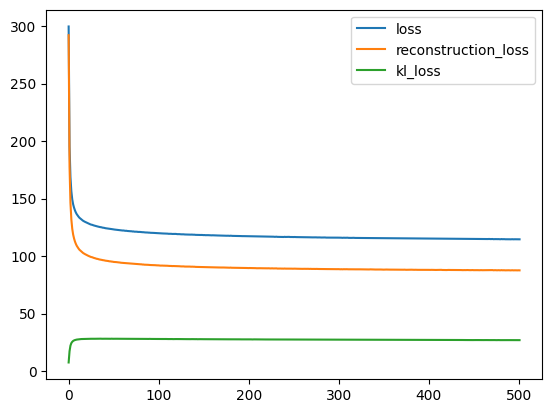

In [37]:
pd.DataFrame(history_dim20.history)[["loss", "reconstruction_loss", "kl_loss"]].plot()

In [39]:
def plot_MNIST2(data, title):
    """

    MNISTのデータをプロットする

    Parameters
    ----------
    data : numpy.ndarray
        数字のモノクロデータ。2次元配列。
    
    title : string
        図のタイトル。

    Returns
    ----------
    None
    """
    
    fig = plt.figure(figsize=(10, 1.5), tight_layout=True)
    fig.suptitle(title)
    
    for i in range(len(data)):
            
        ax = fig.add_subplot(1, len(data), i+1)
        ax.axis("off")
        ax.imshow(data[i], cmap='gray')
        
    return

1/1 [==============================] - 0s 50ms/step


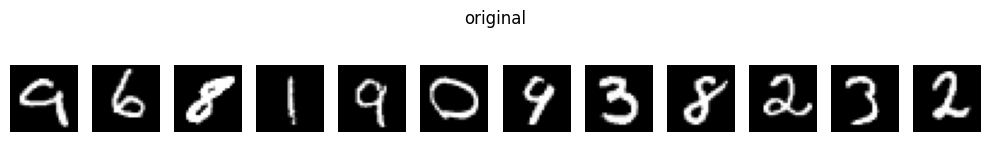

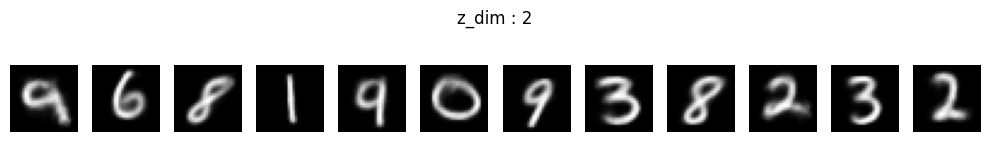

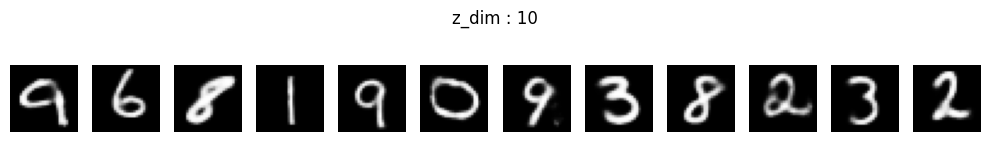

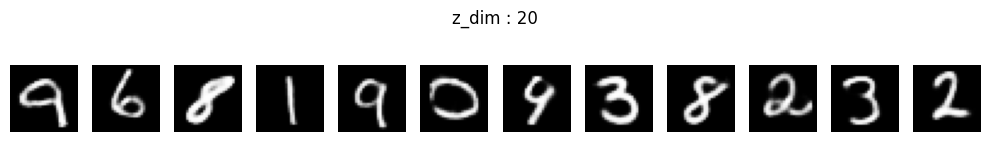

In [40]:
# 再構成画像の描画

num_plot = 12

plot_data = X_train_convert[[random.randint(0, len(X_train_convert)) for i in range(num_plot)]]
plot_MNIST2(np.reshape(plot_data, [-1,28,28]), "original")

for z_dim, model in zip([2, 10, 20], [vae_dim2, vae_dim10, vae_dim20]):
    z_sample = model.encoder.predict(plot_data)[2]
    predict_data = model.decoder.predict(z_sample)
    plot_MNIST2(np.reshape(predict_data, [-1,28,28]), "z_dim : {}".format(z_dim))

In [41]:
type(vae_dim2)

__main__.VAE

In [42]:
def MNIST_decodeDistribution(vae, scale=1.0, n=20):
    """

    潜在変数からデコーダで復元した画像の分布をプロットする。

    Parameters
    ----------
    vae : keras.Model
        訓練済みのVAEモデル。
    
    scale : float
        プロットする潜在空間の範囲。-scaleからscaleまでをプロットする。
        
    n : int
        潜在空間の分割数。-scaleからscaleまでをn分割する。

    Returns
    ----------
    None
    """    
    
    x_scale = np.round(np.linspace(-scale, scale, n+1), decimals=2)
    y_scale = np.round(np.linspace(-scale, scale, n+1)[::-1], decimals=2)
    
    y_temp = []
    bar = tqdm(total=len(x_scale)*len(y_scale), initial=0)

    for y in y_scale:
        x_temp = []

        for x in x_scale:
            z = np.array([[x, y]])
            decoded_data = vae.decoder.predict(z, verbose=0)
            x_temp.append(np.reshape(decoded_data, [28,28]))
            
            bar.update()

        x_concat = np.concatenate(x_temp, 1)
        y_temp.append(x_concat)

    figure_map = np.concatenate(y_temp, 0)
    
    fig = plt.figure(figsize=(10,10), dpi=200, tight_layout=True)

    ax = fig.add_subplot(111)
    ax.set_xticks(np.arange(14, 14+(n+1)*28, 28).tolist()) 
    ax.set_xticklabels(x_scale.tolist(), fontsize=6)
    ax.set_yticks(np.arange(14, 14+(n+1)*28, 28).tolist()) 
    ax.set_yticklabels(y_scale.tolist(), fontsize=6)
    ax.set_xlabel("z[0]", size=10)
    ax.set_ylabel("z[1]", size=10)
    ax.imshow(figure_map, cmap='gray')
    
    return

  0%|          | 0/441 [00:00<?, ?it/s]

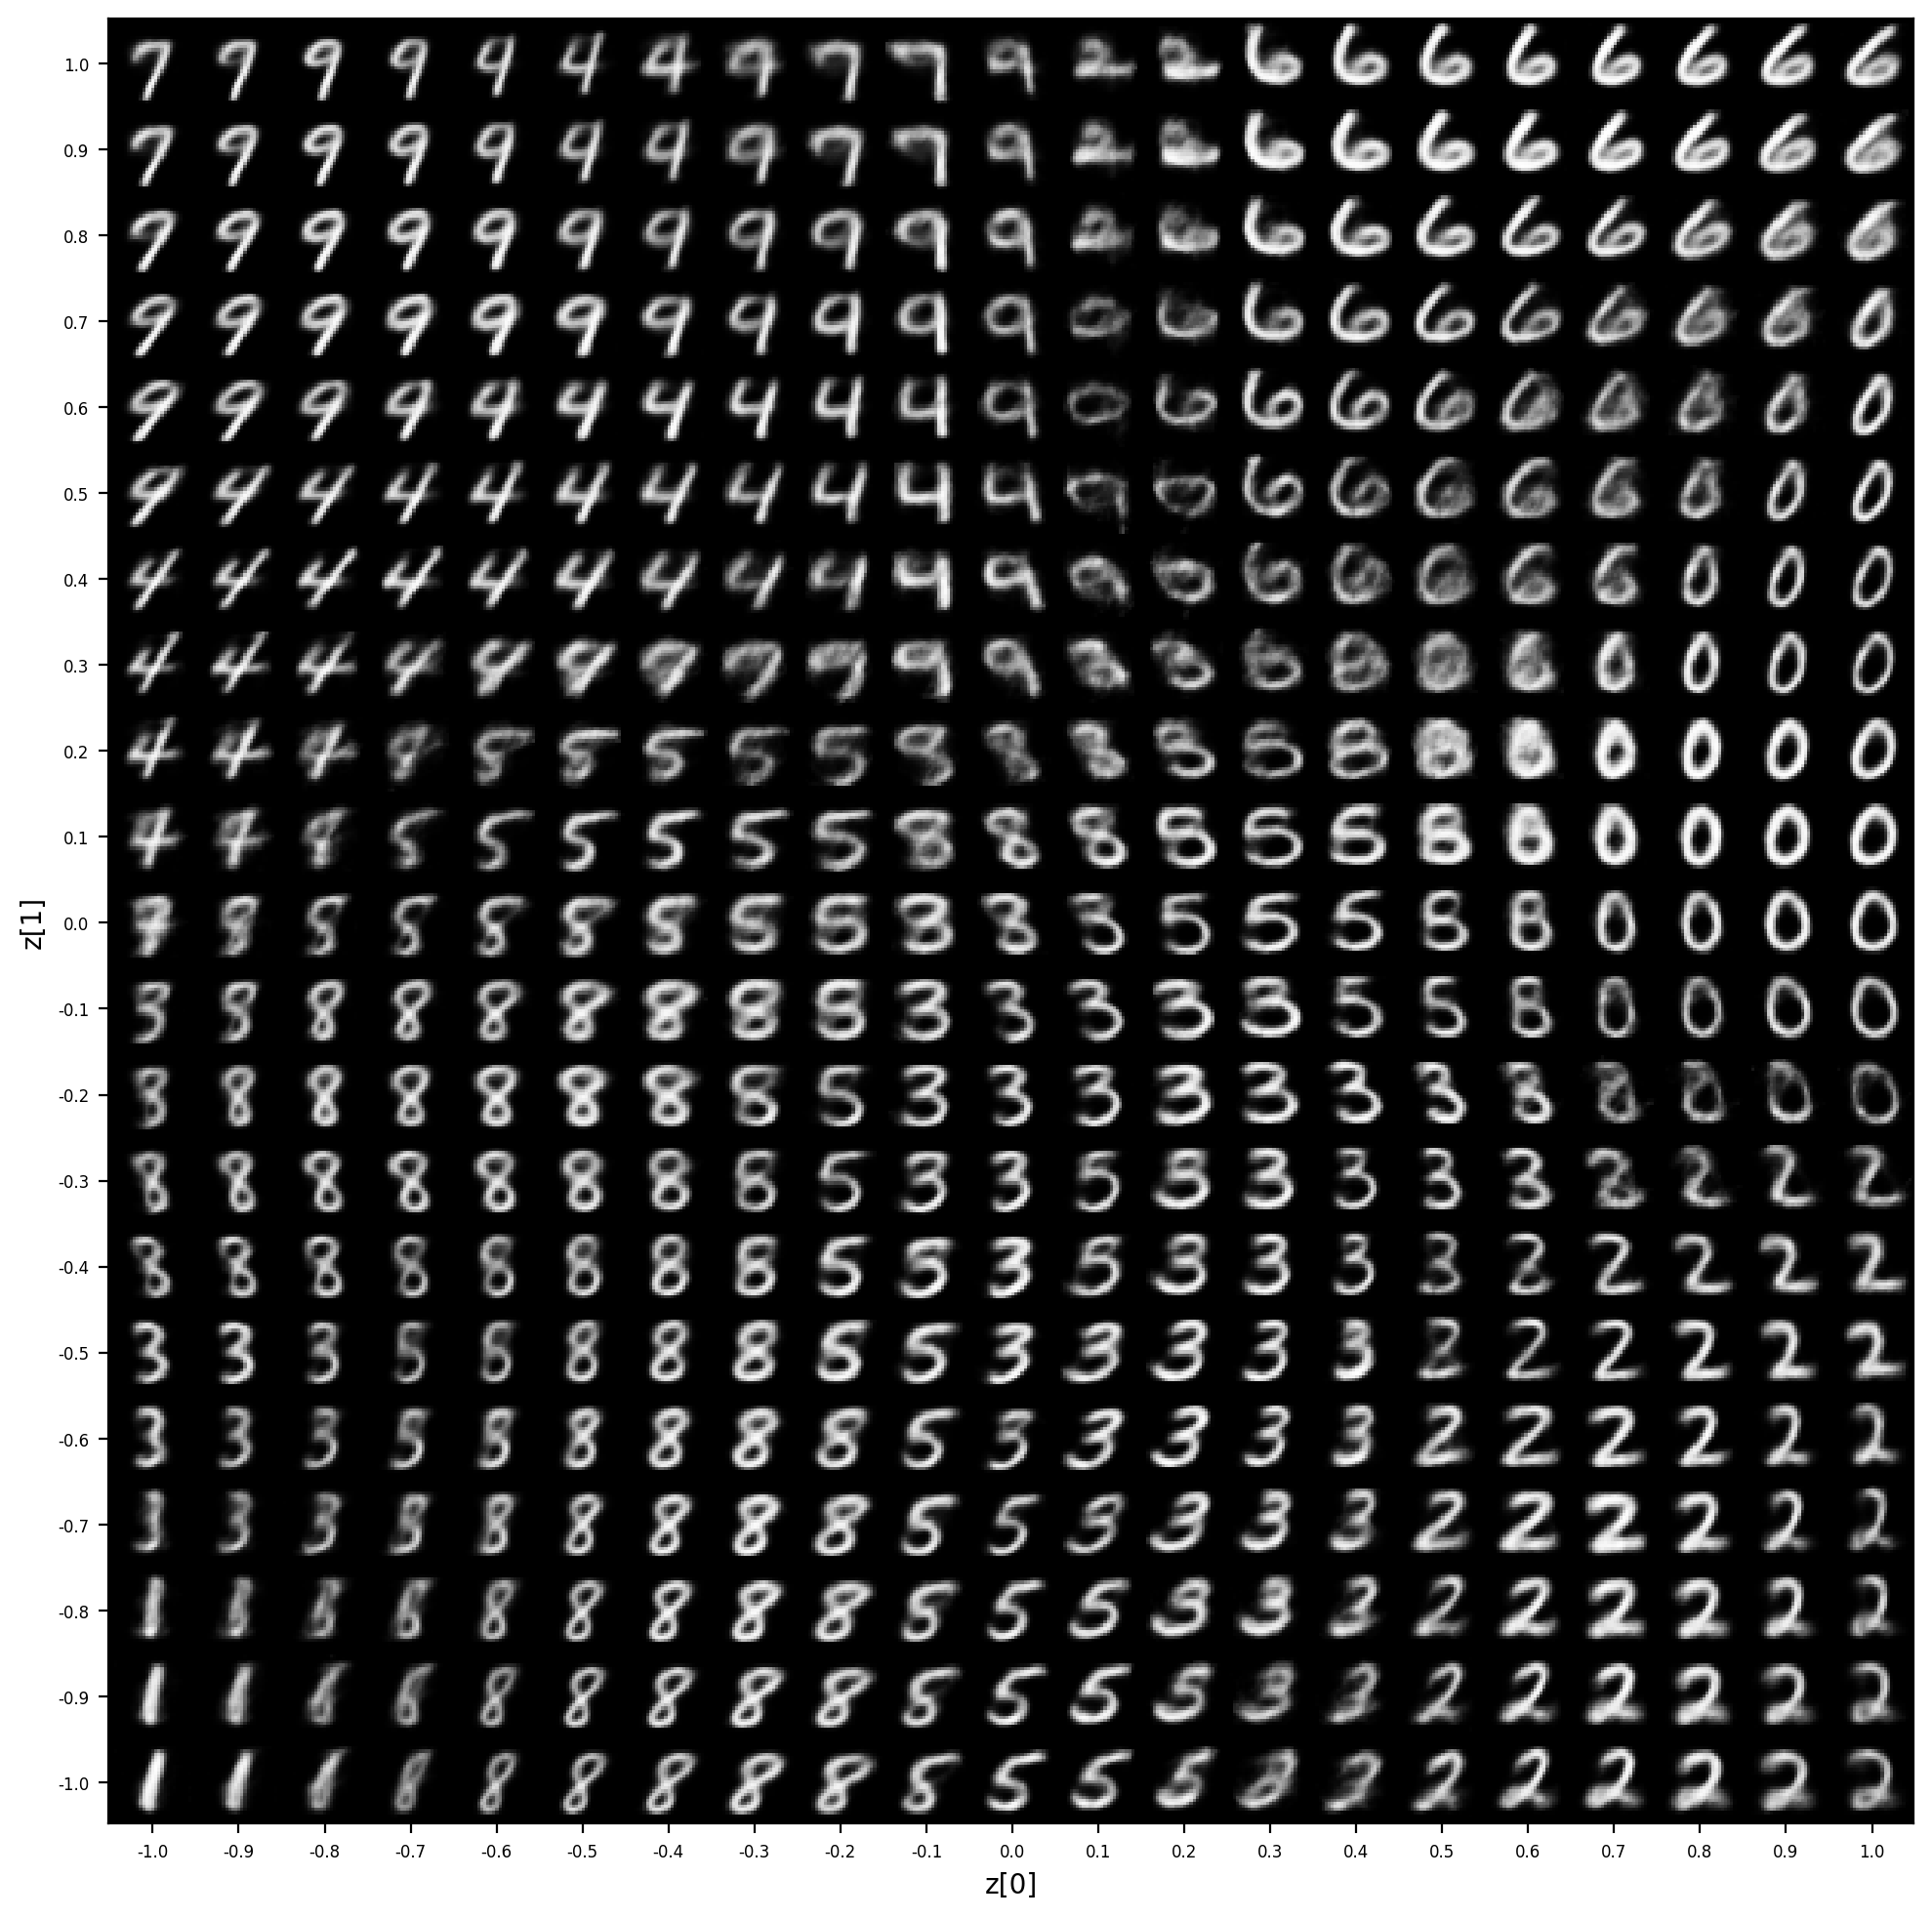

In [43]:
MNIST_decodeDistribution(vae_dim2, scale=1.0, n=20)

  0%|          | 0/1681 [00:00<?, ?it/s]

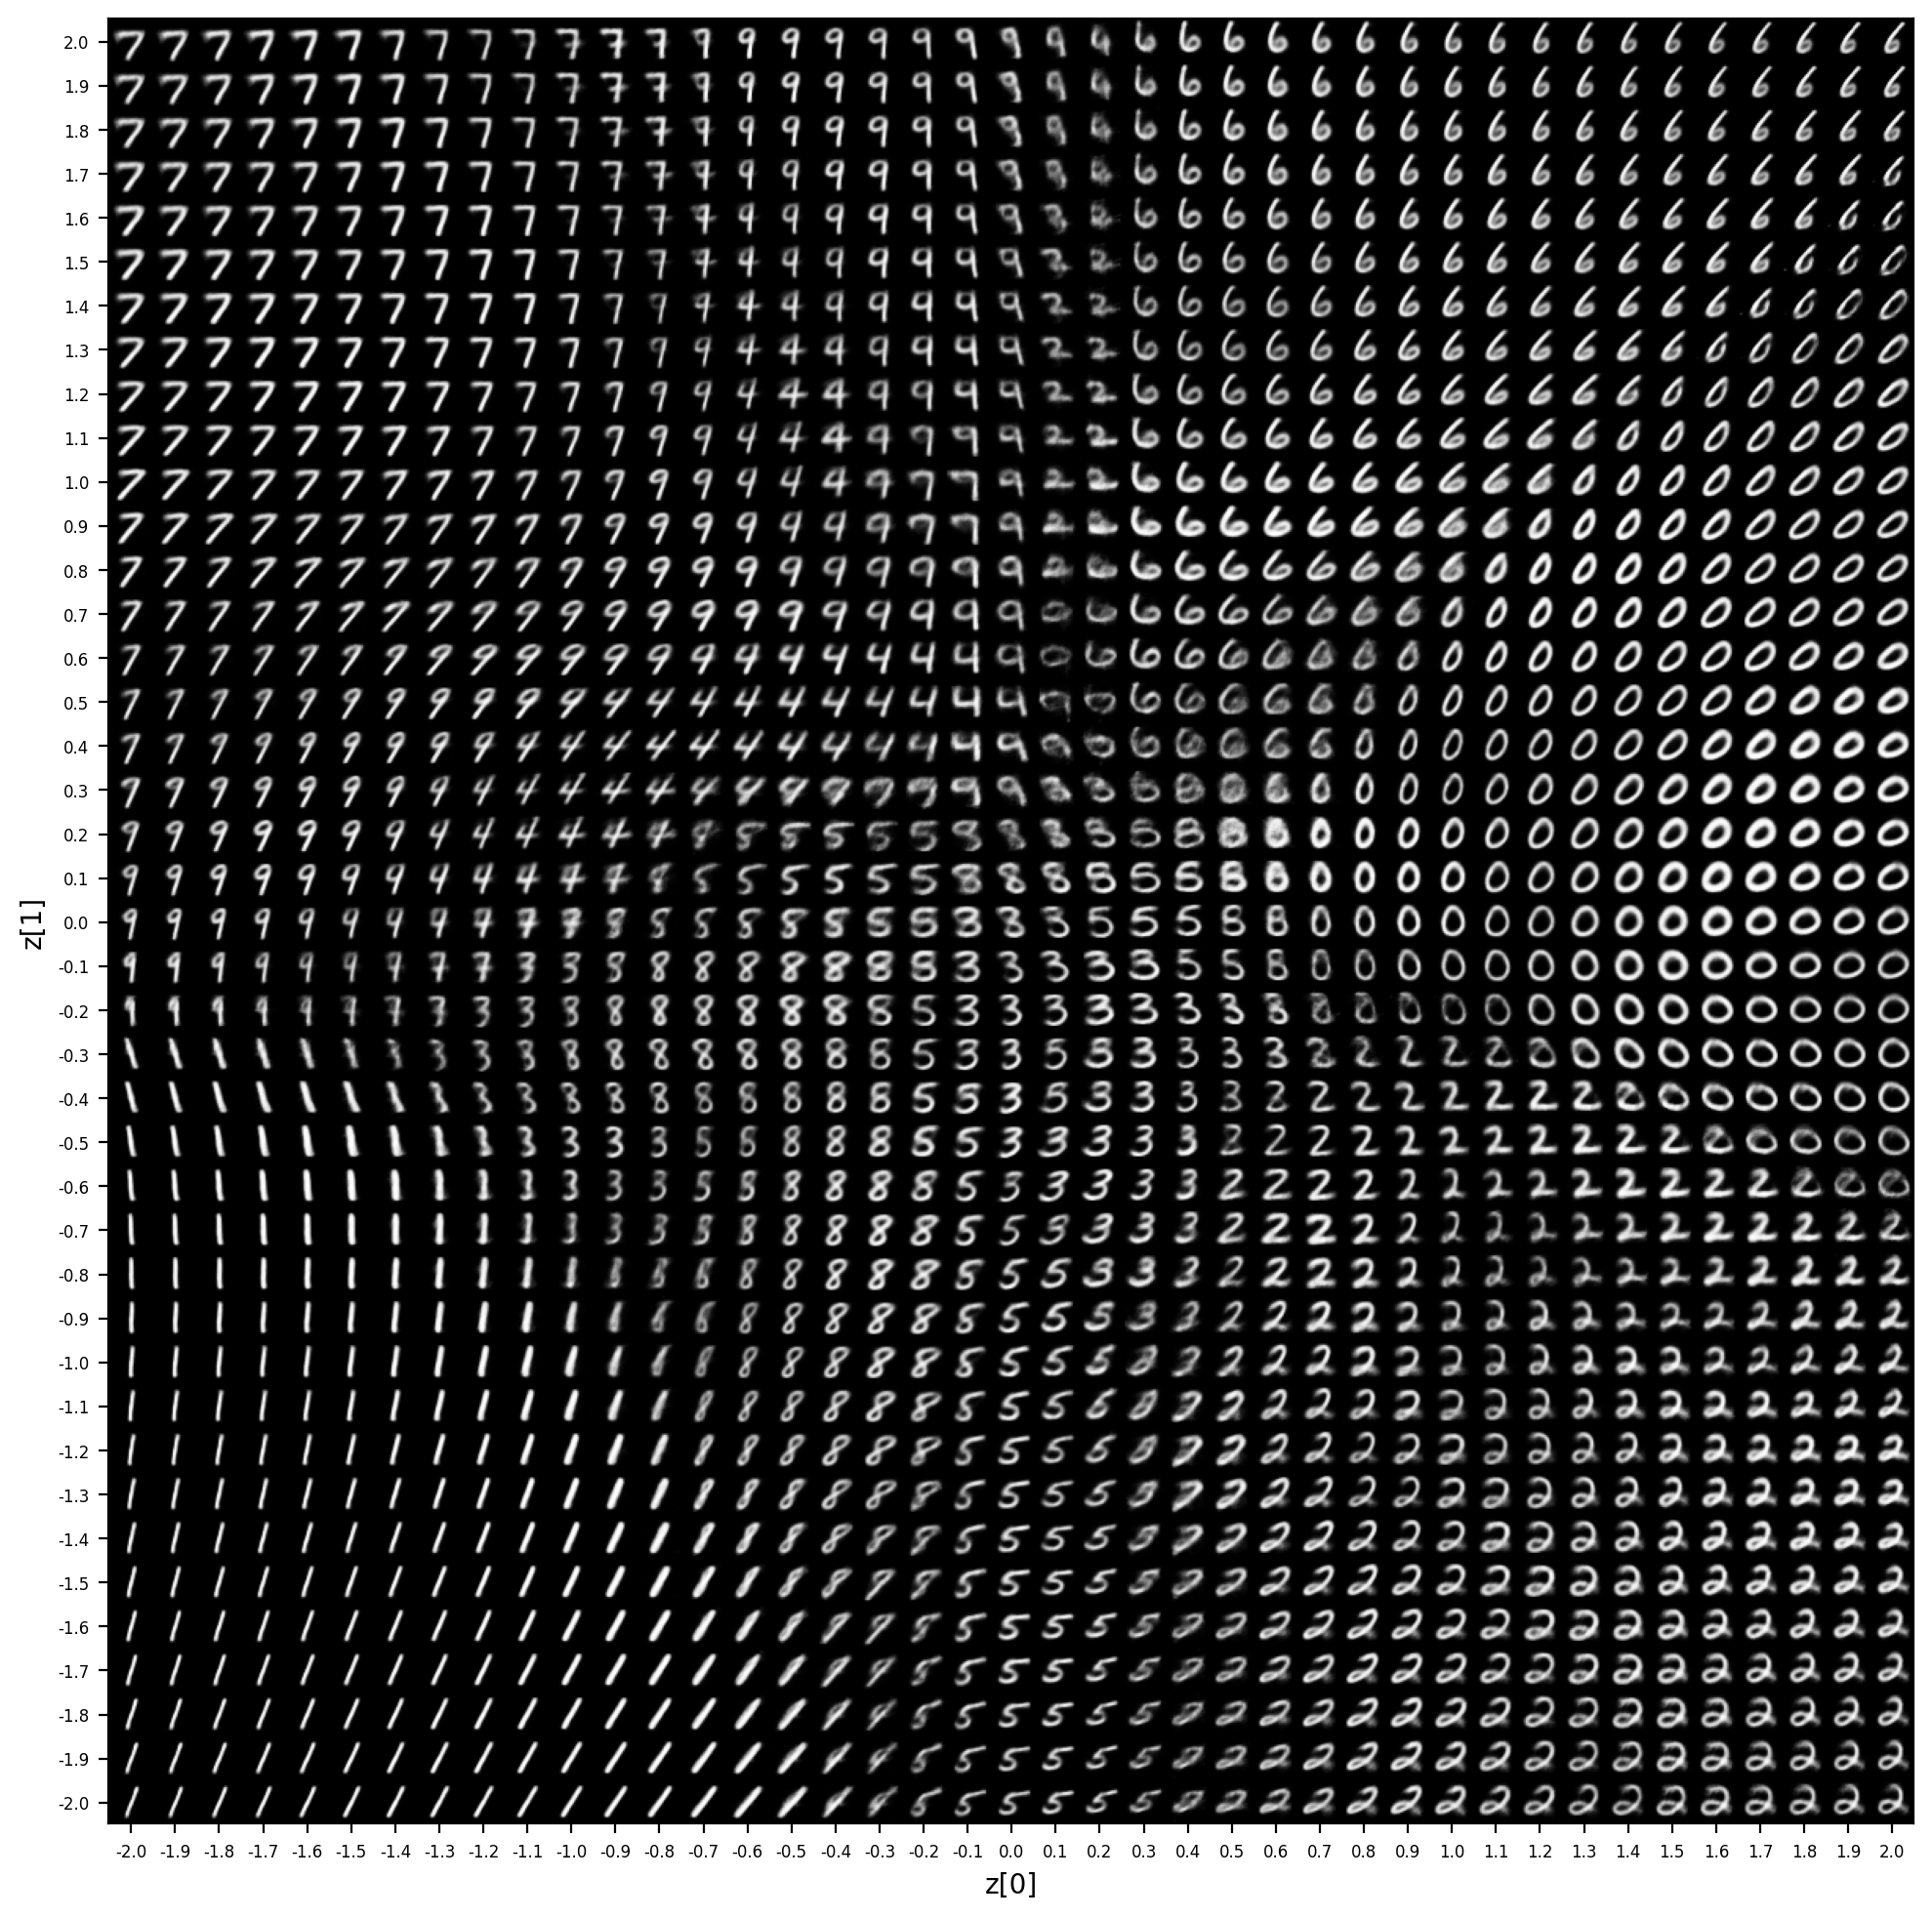

In [44]:
MNIST_decodeDistribution(vae_dim2, scale=2.0, n=40)

In [45]:
def MNIST_encodeDistribution(vae, data, labels):
    """

    入力画像の潜在空間における分布をプロットする。
    言い換えると画像をエンコーダに入力した際の出力のプロット。

    Parameters
    ----------
    vae : keras.Model
        訓練済みのVAEモデル。
    
    data : numpy.ndarray
        MNISTの画像データ。VAEで予測するときの入力の形に変形しておく。
        
    labels : numpy.ndarray
        dataに対応するラベルデータ。

    Returns
    ----------
    None
    """
    
    z_mean, z_log_var, z = vae.encoder.predict(data, verbose=0)
    
    cm = plt.get_cmap("tab10")
    
    fig = plt.figure(figsize=(8,8), dpi=200, tight_layout=True)
    ax = fig.add_subplot(111)
    
    for i in range(0,10):
        plot_data = z_mean[labels==i]
        cs = ax.scatter(plot_data[:, 0], plot_data[:, 1], color=cm(i), marker="${}$".format(i))

    ax.set_xlabel("z[0]", size=10)
    ax.set_ylabel("z[1]", size=10)
    
    return

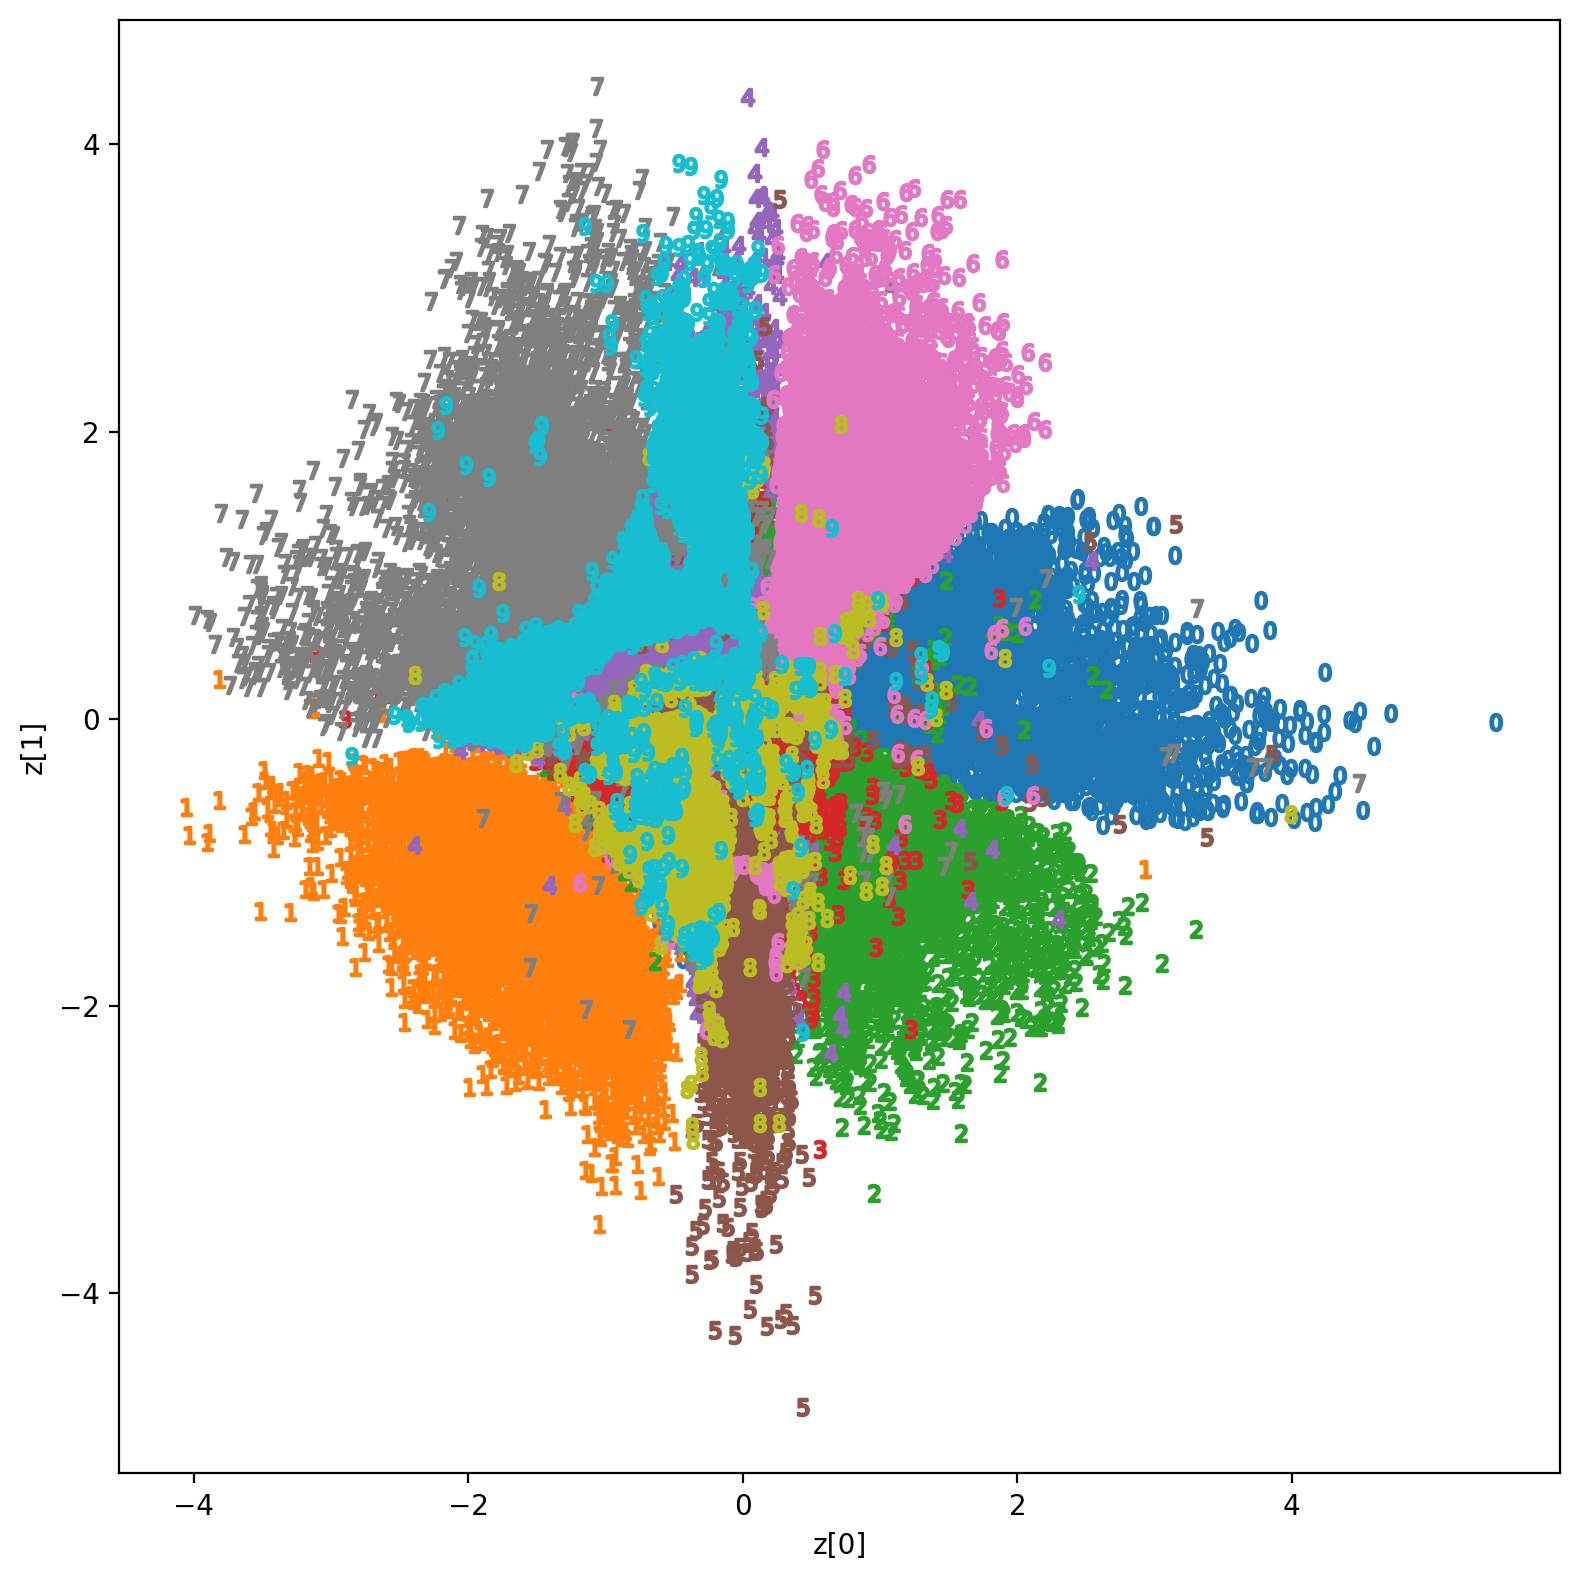

In [46]:
MNIST_encodeDistribution(vae_dim2, X_train_convert, y_train)

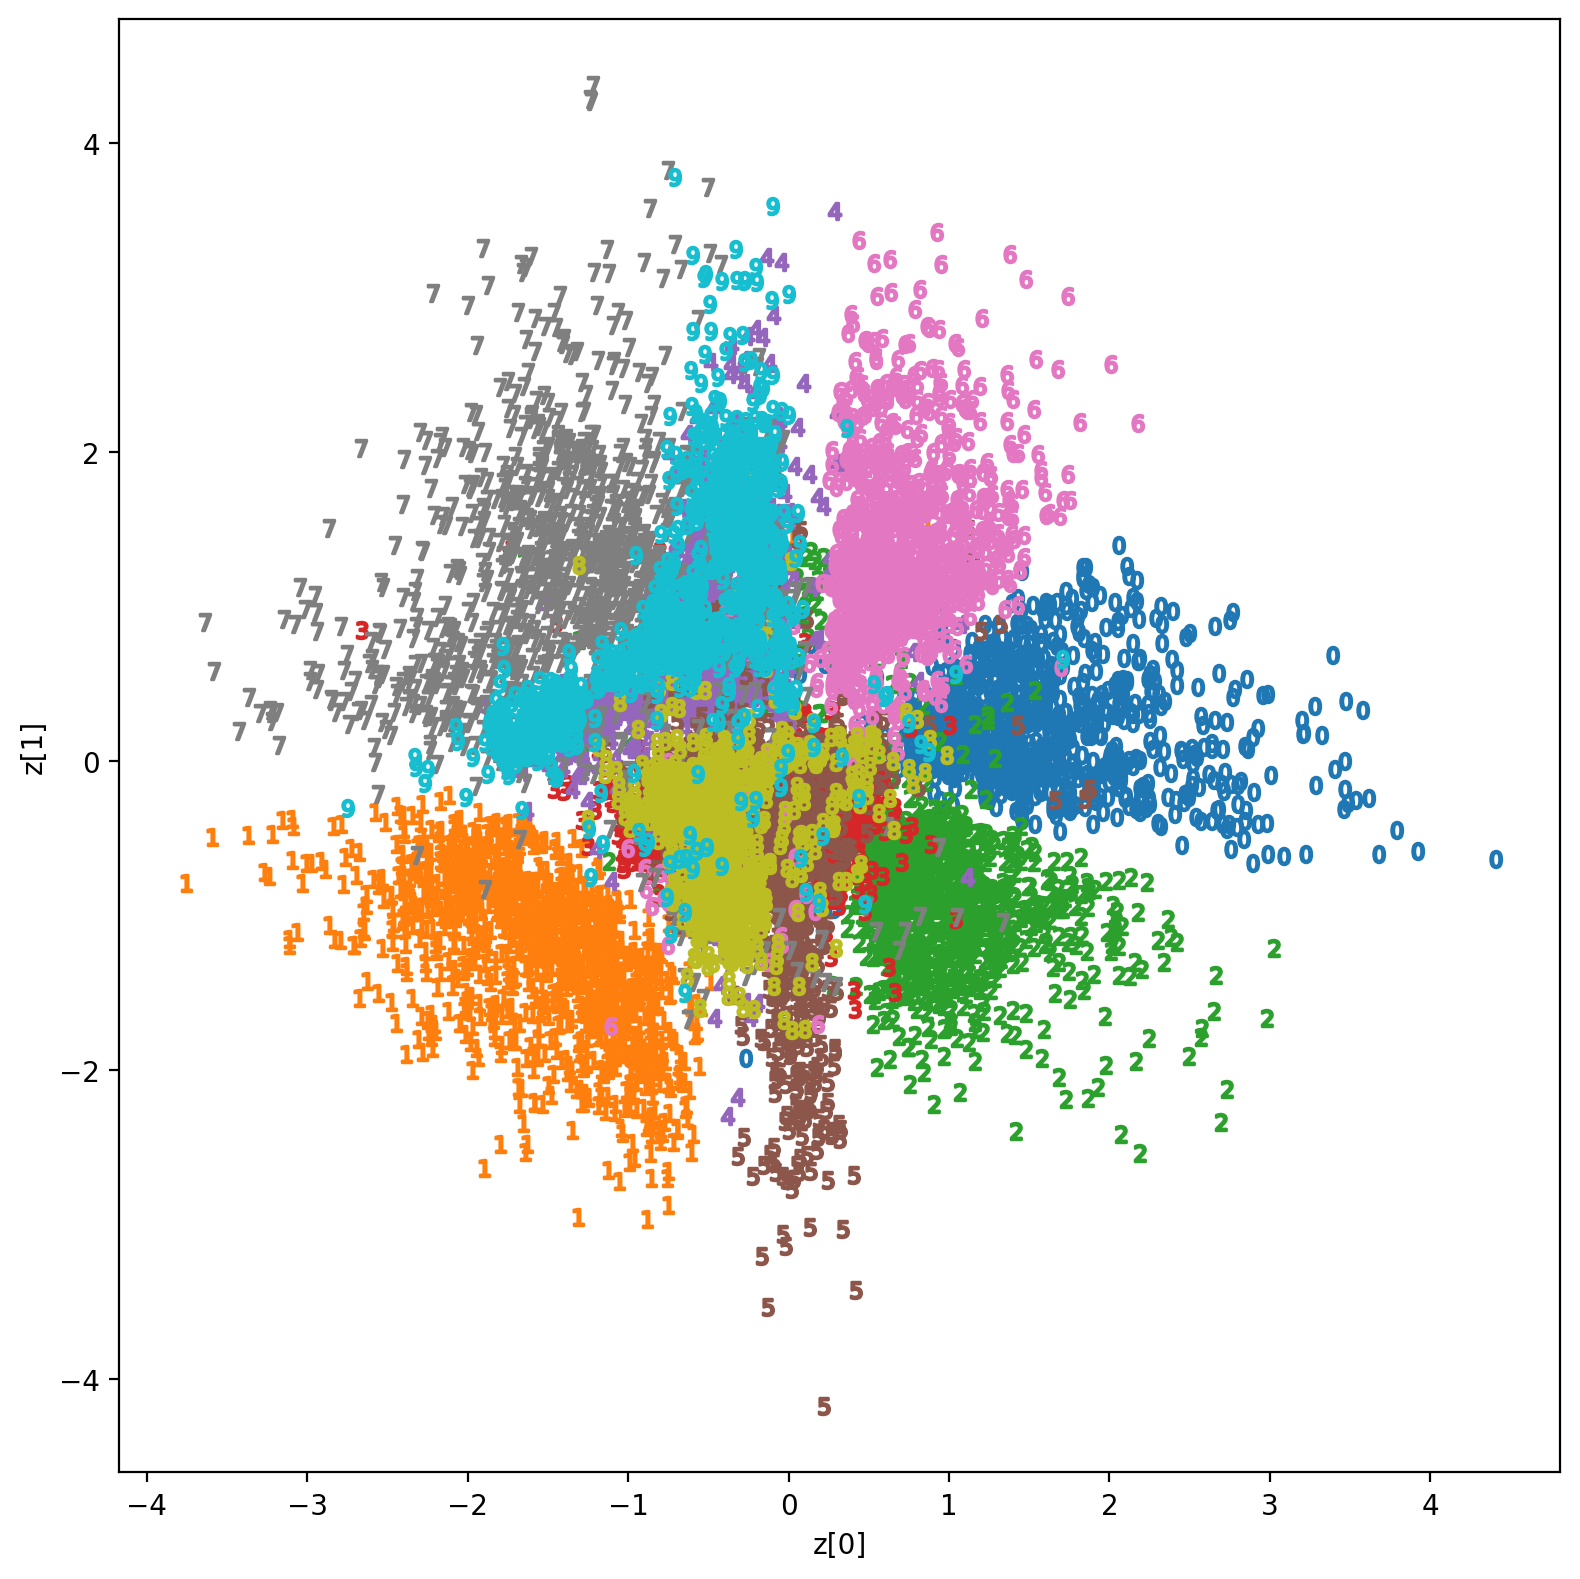

In [47]:
MNIST_encodeDistribution(vae_dim2, X_test_convert, y_test)

In [138]:
z_mean, z_log_var, z = vae_dim2.encoder(X_test_convert)

In [139]:
decoded_data = vae_dim2.decoder(z)

In [140]:
decoded_data.numpy()

array([[1.0942122e-11, 3.2852013e-12, 4.9083988e-12, ..., 1.5473836e-11,
        5.2815239e-12, 5.9765374e-12],
       [6.7089910e-18, 1.3380641e-18, 1.7216774e-18, ..., 1.9695954e-18,
        1.7673804e-18, 3.1549055e-18],
       [1.4648244e-14, 4.5080779e-15, 7.9786633e-15, ..., 4.7339435e-14,
        3.1368574e-14, 6.5843085e-15],
       ...,
       [5.3360094e-12, 5.3024482e-12, 5.2424822e-12, ..., 3.5610566e-12,
        3.5104844e-12, 6.2651134e-12],
       [3.9177114e-14, 1.3271913e-13, 9.5721533e-14, ..., 1.3568564e-14,
        4.9362776e-14, 8.4268618e-14],
       [1.2551587e-12, 4.3077507e-13, 5.5004357e-13, ..., 2.0611820e-12,
        4.0082868e-13, 1.6084161e-12]], dtype=float32)

In [141]:
np.square(z_mean)

array([[2.2428970e+00, 2.1550038e+00],
       [1.0218041e+00, 1.3743334e-01],
       [3.4654469e+00, 2.6357858e+00],
       ...,
       [1.5596019e+00, 8.0668211e-02],
       [7.8878610e-04, 7.3307667e+00],
       [6.9682360e-01, 9.4097883e-01]], dtype=float32)

In [142]:
np.exp(z_log_var)

array([[1.0523229e-03, 8.3401822e-04],
       [1.5371521e-04, 5.5525623e-05],
       [3.7725407e-03, 2.1634209e-03],
       ...,
       [5.5557117e-04, 1.7611960e-04],
       [9.8507197e-05, 3.0310813e-03],
       [2.1834800e-04, 1.8629970e-04]], dtype=float32)

In [143]:
vae_dim2.total_loss_tracker.result().numpy()

0.0

In [151]:
kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
kl_loss

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[4.050352 , 4.1225467],
       [4.401183 , 4.468077 ],
       [4.0246134, 3.887007 ],
       ...,
       [4.027836 , 3.8625958],
       [4.113134 , 6.0663166],
       [4.063231 , 4.2646594]], dtype=float32)>

In [145]:
kl_loss.numpy()

8.214562

In [157]:
reconstruction_loss = tf.reduce_mean(
    tf.reduce_sum(
        keras.losses.binary_crossentropy(X_test_convert, decoded_data)
    )
)

SyntaxError: invalid syntax (2349347532.py, line 1)

In [158]:
reconstruction_loss = tf.reduce_sum(keras.losses.binary_crossentropy(X_test_convert, decoded_data))

In [156]:
keras.losses.binary_crossentropy(X_test_convert, decoded_data).numpy()

array([0.1094982 , 0.17464112, 0.04370505, ..., 0.15429439, 0.18743923,
       0.16809204], dtype=float32)

In [159]:
reconstruction_loss.numpy()/10

176.8418212890625

In [137]:
a = tf.data.Dataset.from_tensor_slices(X_test_convert)
b = a.batch(batch_size=1000)
b

<BatchDataset element_spec=TensorSpec(shape=(None, 784), dtype=tf.float64, name=None)>

In [100]:
z_mean, z_log_var, z = vae_dim20.encoder(b)

TypeError: Inputs to a layer should be tensors. Got: <BatchDataset element_spec=TensorSpec(shape=(None, 784), dtype=tf.float64, name=None)>

In [160]:
type(encoder)

keras.engine.functional.Functional